In [1]:
print("hello, world!")

hello, world!


DEBUG type: <class 'numpy.ndarray'> shape: (256, 256, 3)
DEBUG nan count: 0 inf count: 0


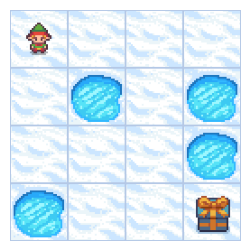

In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        #is_slippery控制会不会滑
        env = gym.make('FrozenLake-v1',
                       render_mode='rgb_array',
                       is_slippery=False)

        super().__init__(env)
        self.env = env

    def reset(self):
        state, _ = self.env.reset()
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        over = terminated or truncated

        #走一步扣一份,逼迫机器人尽快结束游戏
        if not over:
            reward = -1

        #掉坑扣100分
        if over and reward == 0:
            reward = -100

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        import numpy as np
        img = self.env.render()
        print("DEBUG type:", type(img), "shape:", getattr(img, "shape", None))
        if not isinstance(img, np.ndarray):
            try:
                img = np.array(img)
                print("DEBUG after np.array, type:", type(img), "shape:", getattr(img, "shape", None))
            except Exception as e:
                print("ERROR to np.array:", e)
                return
        print("DEBUG nan count:", np.isnan(img).sum(), "inf count:", np.isinf(img).sum())
        plt.figure(figsize=(3, 3))
        plt.imshow(img)
        plt.axis("off")
        plt.show()


env = MyWrapper()

env.reset()

env.show()



In [2]:
import numpy as np

#初始化Q表,定义了每个状态下每个动作的价值
Q = np.zeros((16, 4))

Q

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [3]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        action = Q[state].argmax()
        if random.random() < 0.1:
            action = env.action_space.sample()

        next_state, reward, over = env.step(action)

        data.append((state, action, reward, next_state, over))
        reward_sum += reward

        state = next_state

        if show:
            display.clear_output(wait=True)
            env.show()

    return data, reward_sum


play()[-1]

d:\it_project\github_sync\ml-workshop\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


-116

In [4]:
#数据池
class Pool:

    def __init__(self):
        self.pool = []

    def __len__(self):
        return len(self.pool)

    def __getitem__(self, i):
        return self.pool[i]

    #更新动作池
    def update(self):
        #每次更新不少于N条新数据
        old_len = len(self.pool)
        while len(pool) - old_len < 200:
            self.pool.extend(play()[0])

        #只保留最新的N条数据
        self.pool = self.pool[-1_0000:]

    #获取一批数据样本
    def sample(self):
        return random.choice(self.pool)


pool = Pool()
pool.update()

len(pool), pool[0]

(225, (0, 0, -1, 0, False))

In [5]:
#训练
def train():
    #共更新N轮数据
    for epoch in range(1000):
        pool.update()

        #每次更新数据后,训练N次
        for i in range(200):

            #随机抽一条数据
            state, action, reward, next_state, over = pool.sample()

            #Q矩阵当前估计的state下action的价值
            value = Q[state, action]

            #实际玩了之后得到的reward+下一个状态的价值*0.9
            target = reward + Q[next_state].max() * 0.9

            #value和target应该是相等的,说明Q矩阵的评估准确
            #如果有误差,则应该以target为准更新Q表,修正它的偏差
            #这就是TD误差,指评估值之间的偏差,以实际成分高的评估为准进行修正
            update = (target - value) * 0.1

            #更新Q表
            Q[state, action] += update

        if epoch % 100 == 0:
            print(epoch, len(pool), play()[-1])


train()

0 502 -109
100 10000 -6.0
200 10000 -4.0
300 10000 -4.0
400 10000 -103
500 10000 -6.0
600 10000 -103
700 10000 -4.0
800 10000 -4.0
900 10000 -4.0


In [ ]:
play(True)[-1]